Bibliotecas Utilizadas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, SimpleRNN, Bidirectional
import tensorflow as tf
import kagglehub
from collections import Counter


In [ ]:
# 1. Carregar a base de dados

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from google.colab import files
uploaded = files.upload()

df = pd.read_csv('sentiment-emotion-labelled_Dell_tweets.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving sentiment-emotion-labelled_Dell_tweets.csv to sentiment-emotion-labelled_Dell_tweets.csv


In [ ]:
# 2. Limpeza de texto
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\S+|#\S+|[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['Text'].apply(preprocess_text)

# Sentimentos (Positivo, Neutro, Negativo)

sentiment
negative    10556
positive     7366
neutral      7048
Name: count, dtype: int64


Tamanho treino balanceado: 21000
Tamanho restante para teste: 3970




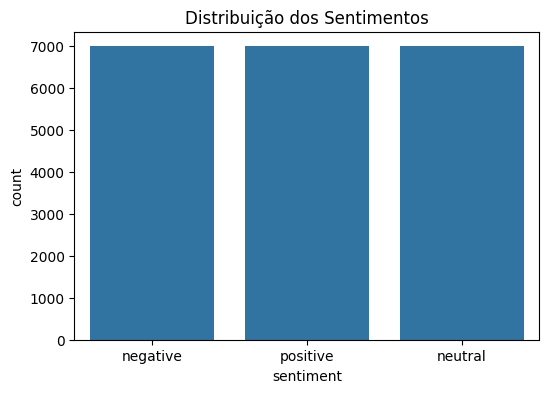

In [ ]:
# 3. Balancear: pegar 7000 de cada sentimento
print(df['sentiment'].value_counts())
print('\n')

train_samples = []
test_samples = []

for sentiment in df['sentiment'].unique():
    df_sentiment = df[df['sentiment'] == sentiment]
    df_train = df_sentiment.sample(n=7000, random_state=42)
    df_test = df_sentiment.drop(df_train.index)

    train_samples.append(df_train)
    test_samples.append(df_test)

df_train_balanced = pd.concat(train_samples).sample(frac=1, random_state=42)  # Embaralhar
df_test_rest = pd.concat(test_samples)

print(f"Tamanho treino balanceado: {len(df_train_balanced)}")
print(f"Tamanho restante para teste: {len(df_test_rest)}")

print('\n')

# Visualização dos sentimentos
plt.figure(figsize=(6,4))
sns.countplot(data=df_train_balanced, x='sentiment', order=df['sentiment'].value_counts().index)
plt.title('Distribuição dos Sentimentos')
plt.show()

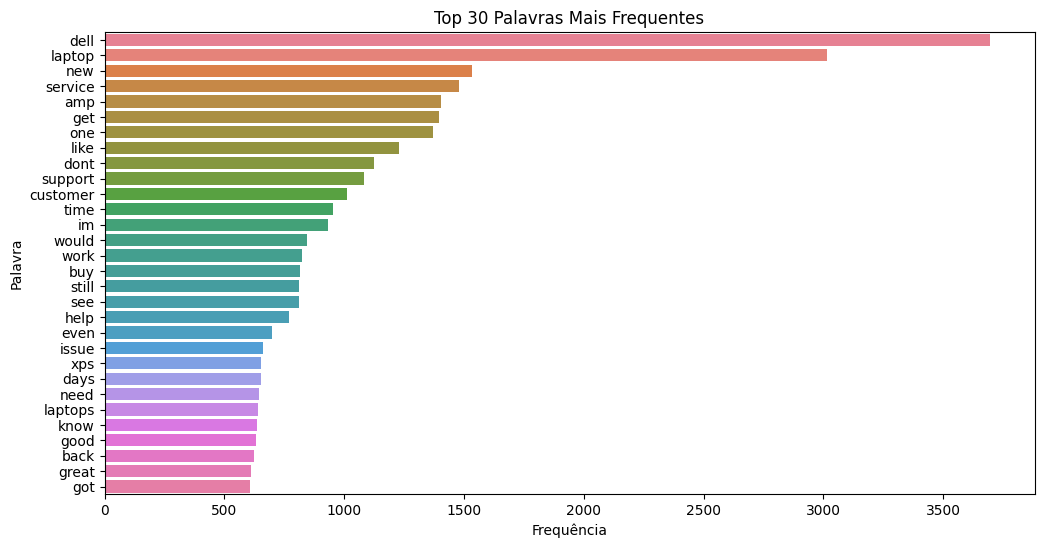

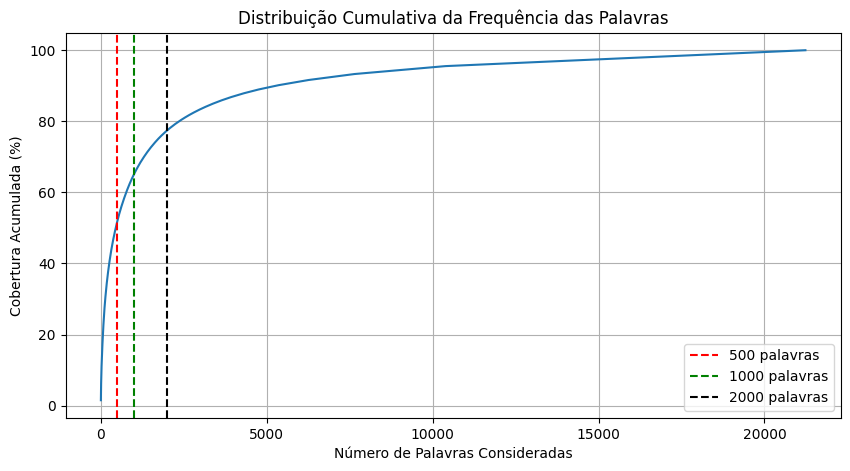

In [ ]:
# 4. Contar frequência das palavras
all_tokens = []
for text in df_train_balanced['clean_text']:
    all_tokens += text.split()

# Contar as palavras
word_freq = Counter(all_tokens)

# Converter para DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# Plotar as 30 palavras mais comuns
plt.figure(figsize=(12,6))
sns.barplot(data=word_freq_df.head(30), x='freq', y='word', hue='word', dodge=False, legend=False)
plt.title('Top 30 Palavras Mais Frequentes')
plt.xlabel('Frequência')
plt.ylabel('Palavra')
plt.show()

print('\n')

# Plotar distribuição cumulativa
word_freq_df['cum_freq'] = word_freq_df['freq'].cumsum()
word_freq_df['cum_perc'] = 100 * word_freq_df['cum_freq'] / word_freq_df['freq'].sum()

plt.figure(figsize=(10,5))
plt.plot(range(1, len(word_freq_df)+1), word_freq_df['cum_perc'])
plt.axvline(500, color='r', linestyle='--', label='500 palavras')
plt.axvline(1000, color='g', linestyle='--', label='1000 palavras')
plt.axvline(2000, color='black', linestyle='--', label='2000 palavras')
plt.xlabel('Número de Palavras Consideradas')
plt.ylabel('Cobertura Acumulada (%)')
plt.title('Distribuição Cumulativa da Frequência das Palavras')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 5. Separar o balanceado em treino e teste (20% para teste)
train_df, val_df = train_test_split(df_train_balanced, test_size=0.2, stratify=df_train_balanced['sentiment'], random_state=42)

# Concatenar a validação com o restante da base
test_df = pd.concat([val_df, df_test_rest]).reset_index(drop=True)

# Checar tamanhos
print(f"Tamanho do treino: {len(train_df)}")
print(f"Tamanho do teste/validação: {len(test_df)}")

Tamanho do treino: 16800
Tamanho do teste/validação: 8170


In [ ]:
# 6. Tokenização
max_words = 1000
max_len = 144

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['clean_text'])

# Treino
X_train = tokenizer.texts_to_sequences(train_df['clean_text'])
X_train = pad_sequences(X_train, maxlen=max_len)

# Teste
X_test = tokenizer.texts_to_sequences(test_df['clean_text'])
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
# 7. Codificar rótulos
encoder = LabelEncoder()

y_train = encoder.fit_transform(train_df['sentiment'])
y_test = encoder.transform(test_df['sentiment'])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## LTSM

In [ ]:
# 8. Criar o modelo
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    LSTM(16, dropout=0.4, recurrent_dropout=0.4),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

# 9. Treinar
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 144, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,163 (70.95 KB)

 Trainable params: 18,163 (70.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - categorical_accuracy: 0.4420 - loss: 1.0723 - val_categorical_accuracy: 0.5149 - val_loss: 0.9589
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - categorical_accuracy: 0.5283 - loss: 0.9375 - val_categorical_accuracy: 0.6054 - val_loss: 0.8550
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - categorical_accuracy: 0.5954 - loss: 0.8389 - val_categorical_accuracy: 0.6589 - val_loss: 0.7931
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - categorical_accuracy: 0.6548 - loss: 0.7766 - val_categorical_accuracy: 0.6664 - val_loss: 0.7543
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - categorical_accuracy: 0.6863 - loss: 0.7293 - val_categorical_accuracy: 0.6801 - val_loss: 0.7295
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - categorical_accuracy: 0.7100 - loss: 0.6924 - val_categorical_accuracy: 0.6875 - val_loss: 0.7154
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - categorical_a

In [ ]:
# 10. Avaliar
loss, acc = model.evaluate(X_test, y_test)
print(f"Acurácia no teste: {acc:.2%}")

256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - categorical_accuracy: 0.7011 - loss: 0.7143
Acurácia no teste: 72.02%


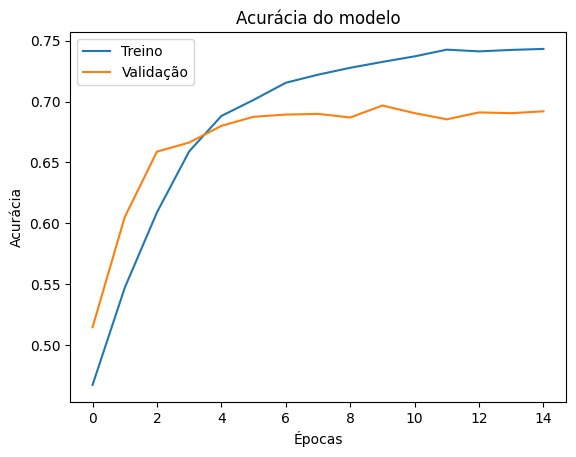

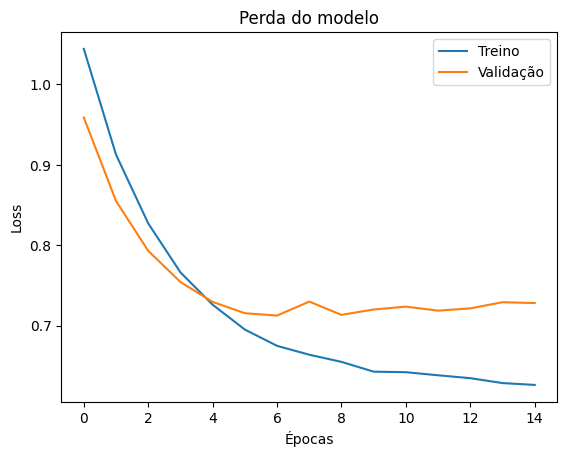

In [ ]:
# 11. Plotar métricas
plt.plot(history.history['categorical_accuracy'], label='Treino')
plt.plot(history.history['val_categorical_accuracy'], label='Validação')
plt.title('Acurácia do modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


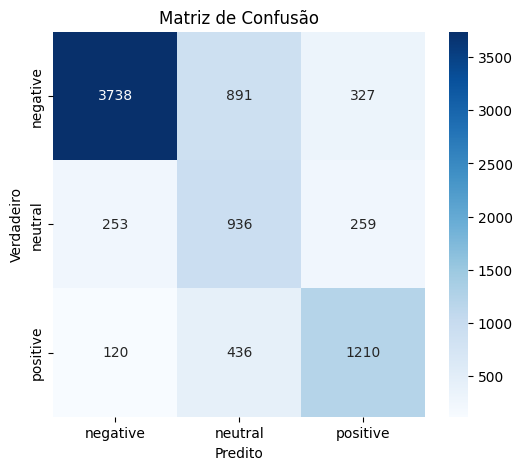



              precision    recall  f1-score   support

    negative       0.91      0.75      0.82      4956
     neutral       0.41      0.65      0.50      1448
    positive       0.67      0.69      0.68      1766

    accuracy                           0.72      8170
   macro avg       0.67      0.70      0.67      8170
weighted avg       0.77      0.72      0.74      8170



In [ ]:
# 12. Matriz de confusão e classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print('\n')
print(classification_report(y_true, y_pred, target_names=labels))


## GRU

In [ ]:
# 8. Criar o modelo
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    GRU(16, dropout=0.4, recurrent_dropout=0.4),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

# 9. Treinar
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 144, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,683 (69.07 KB)

 Trainable params: 17,683 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - categorical_accuracy: 0.4068 - loss: 1.0861 - val_categorical_accuracy: 0.5574 - val_loss: 0.9816
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - categorical_accuracy: 0.5667 - loss: 0.9472 - val_categorical_accuracy: 0.6414 - val_loss: 0.8000
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - categorical_accuracy: 0.6507 - loss: 0.8017 - val_categorical_accuracy: 0.6720 - val_loss: 0.7438
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - categorical_accuracy: 0.6885 - loss: 0.7449 - val_categorical_accuracy: 0.6747 - val_loss: 0.7330
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - categorical_accuracy: 0.6934 - loss: 0.7209 - val_categorical_accuracy: 0.6866 - val_loss: 0.7152
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - categorical_accuracy: 0.7076 - loss: 0.6920 - val_categorical_accuracy: 0.6851 - val_loss: 0.7102
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - categorical_ac

In [ ]:
# 10. Avaliar
loss, acc = model.evaluate(X_test, y_test)
print(f"Acurácia no teste: {acc:.2%}")

256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - categorical_accuracy: 0.7000 - loss: 0.7023
Acurácia no teste: 72.00%


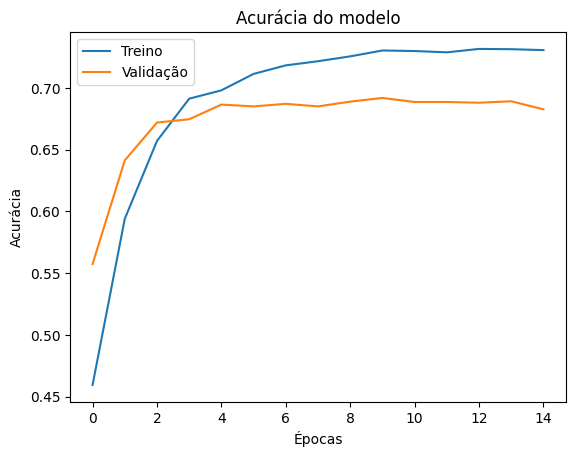

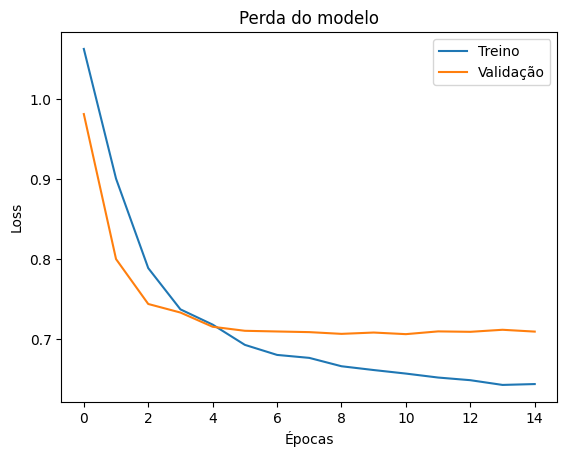

In [ ]:
# 11. Plotar métricas
plt.plot(history.history['categorical_accuracy'], label='Treino')
plt.plot(history.history['val_categorical_accuracy'], label='Validação')
plt.title('Acurácia do modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


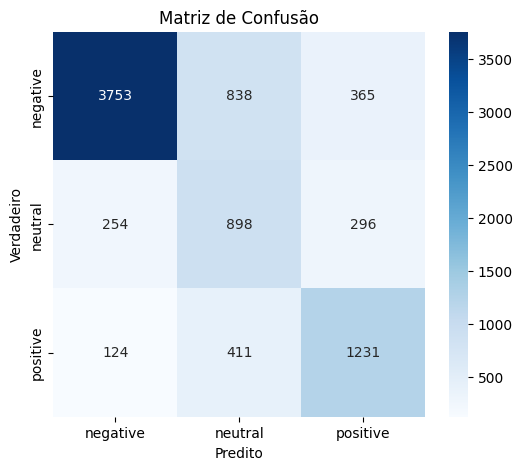



              precision    recall  f1-score   support

    negative       0.91      0.76      0.83      4956
     neutral       0.42      0.62      0.50      1448
    positive       0.65      0.70      0.67      1766

    accuracy                           0.72      8170
   macro avg       0.66      0.69      0.67      8170
weighted avg       0.77      0.72      0.74      8170



In [ ]:
# 12. Matriz de confusão e classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print('\n')
print(classification_report(y_true, y_pred, target_names=labels))

## SimpleRNN layer

In [ ]:
# 8. Criar o modelo
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    SimpleRNN(16, dropout=0.4, recurrent_dropout=0.4),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

# 9. Treinar
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 144, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,579 (64.76 KB)

 Trainable params: 16,579 (64.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - categorical_accuracy: 0.3309 - loss: 1.2932 - val_categorical_accuracy: 0.2860 - val_loss: 1.1042
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - categorical_accuracy: 0.3375 - loss: 1.1978 - val_categorical_accuracy: 0.3417 - val_loss: 1.1276
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - categorical_accuracy: 0.3481 - loss: 1.1467 - val_categorical_accuracy: 0.3518 - val_loss: 1.0912
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - categorical_accuracy: 0.3487 - loss: 1.1218 - val_categorical_accuracy: 0.3661 - val_loss: 1.0899
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - categorical_accuracy: 0.3515 - loss: 1.1112 - val_categorical_accuracy: 0.4057 - val_loss: 1.0873
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - categorical_accuracy: 0.3655 - loss: 1.0995 - val_categorical_accuracy: 0.5217 - val_loss: 1.0806
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - categorical_accuracy: 0.368

In [ ]:
# 10. Avaliar
loss, acc = model.evaluate(X_test, y_test)
print(f"Acurácia no teste: {acc:.2%}")

256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - categorical_accuracy: 0.5674 - loss: 1.0125
Acurácia no teste: 67.18%


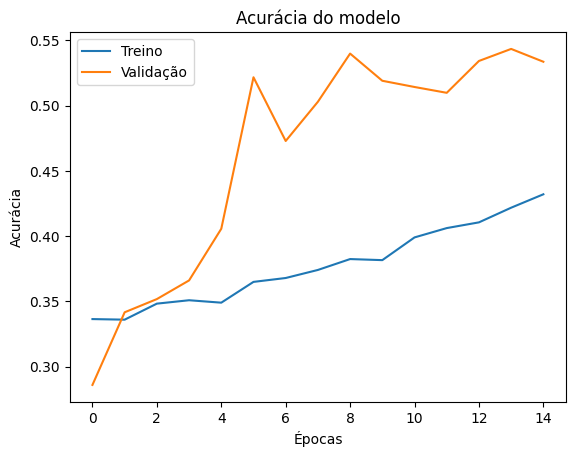

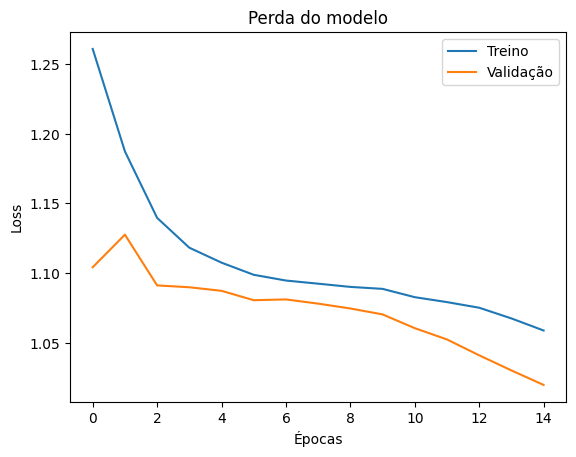

In [ ]:
# 11. Plotar métricas
plt.plot(history.history['categorical_accuracy'], label='Treino')
plt.plot(history.history['val_categorical_accuracy'], label='Validação')
plt.title('Acurácia do modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


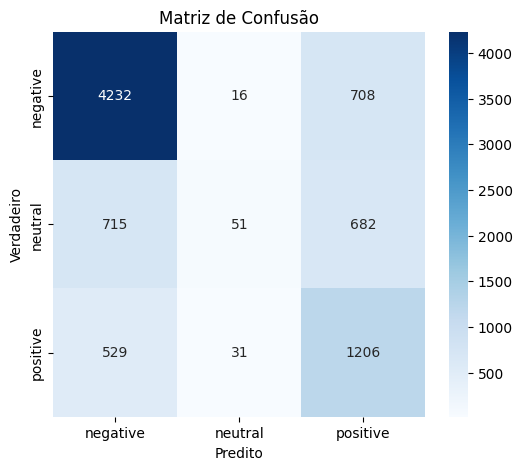



              precision    recall  f1-score   support

    negative       0.77      0.85      0.81      4956
     neutral       0.52      0.04      0.07      1448
    positive       0.46      0.68      0.55      1766

    accuracy                           0.67      8170
   macro avg       0.59      0.52      0.48      8170
weighted avg       0.66      0.67      0.62      8170



In [ ]:
# 12. Matriz de confusão e classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print('\n')
print(classification_report(y_true, y_pred, target_names=labels))

## Bidirectional layer

In [ ]:
# 8. Criar o modelo
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    Bidirectional(LSTM(16, dropout=0.4, recurrent_dropout=0.4)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

# 9. Treinar
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 144, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,323 (79.39 KB)

 Trainable params: 20,323 (79.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - categorical_accuracy: 0.3819 - loss: 1.0868 - val_categorical_accuracy: 0.5196 - val_loss: 0.9758
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - categorical_accuracy: 0.5263 - loss: 0.9508 - val_categorical_accuracy: 0.6235 - val_loss: 0.8323
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - categorical_accuracy: 0.6267 - loss: 0.8170 - val_categorical_accuracy: 0.6515 - val_loss: 0.7683
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - categorical_accuracy: 0.6603 - loss: 0.7632 - val_categorical_accuracy: 0.6810 - val_loss: 0.7378
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - categorical_accuracy: 0.6921 - loss: 0.7152 - val_categorical_accuracy: 0.6872 - val_loss: 0.7223
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - categorical_accuracy: 0.7143 - loss: 0.6802 - val_categorical_accuracy: 0.6943 - val_loss: 0.7158
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - categorical_a

In [ ]:
# 10. Avaliar
loss, acc = model.evaluate(X_test, y_test)
print(f"Acurácia no teste: {acc:.2%}")

256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - categorical_accuracy: 0.7032 - loss: 0.7124
Acurácia no teste: 73.24%


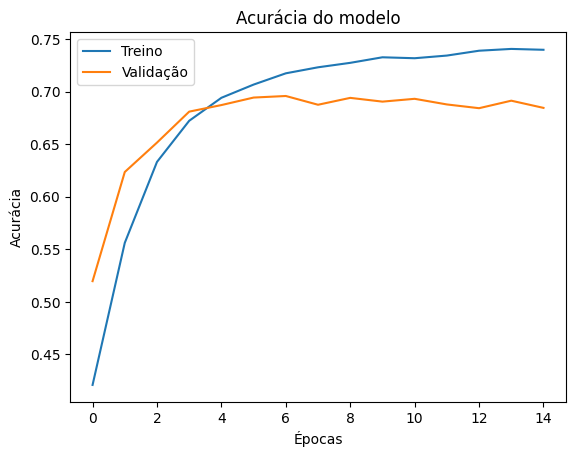

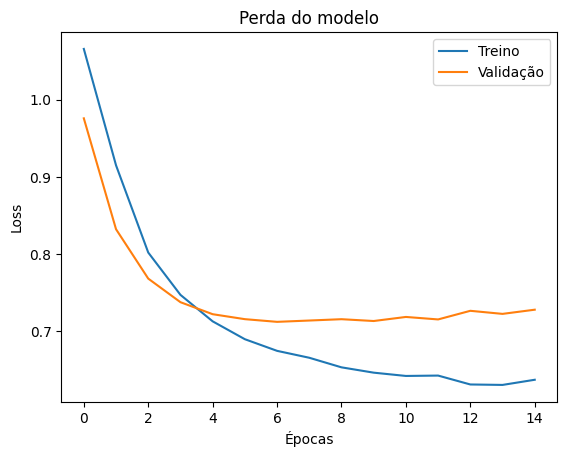

In [ ]:
# 11. Plotar métricas
plt.plot(history.history['categorical_accuracy'], label='Treino')
plt.plot(history.history['val_categorical_accuracy'], label='Validação')
plt.title('Acurácia do modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step


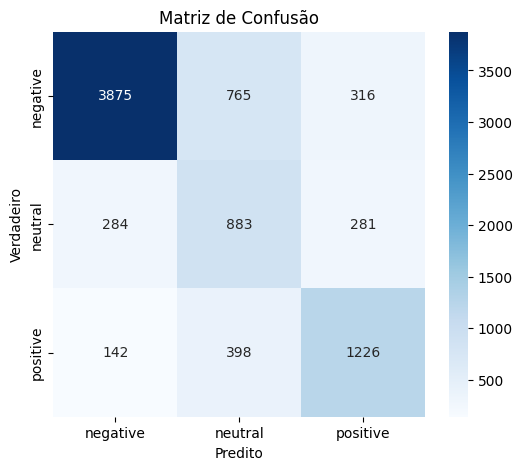



              precision    recall  f1-score   support

    negative       0.90      0.78      0.84      4956
     neutral       0.43      0.61      0.51      1448
    positive       0.67      0.69      0.68      1766

    accuracy                           0.73      8170
   macro avg       0.67      0.70      0.68      8170
weighted avg       0.77      0.73      0.75      8170



In [ ]:
# 12. Matriz de confusão e classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print('\n')
print(classification_report(y_true, y_pred, target_names=labels))

# Emoções

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
# 3. Contagem de classes nas emoções
print("\nDistribuição das emoções:")
print(df['emotion'].value_counts())


Distribuição das emoções:
emotion
anger           7520
joy             6326
anticipation    5171
disgust         3000
sadness         1328
optimism        1225
fear             366
surprise          34
Name: count, dtype: int64


In [ ]:
# 4. Tokenização
max_words = 1000
max_len = 144

tokenizer_emotion = Tokenizer(num_words=max_words)
tokenizer_emotion.fit_on_texts(df['clean_text'])

X_full_padded = pad_sequences(tokenizer_emotion.texts_to_sequences(df['clean_text']), maxlen=max_len)

In [ ]:
# 5. Codificar rotulos
encoder_emotion = LabelEncoder()
y_full_numerical = encoder_emotion.fit_transform(df['emotion'])

In [ ]:
# 6. Balanceamento de emoções

original_counts = Counter(y_full_numerical) # contador
target_count_per_class = 3500 # valores alvo para todas as classes

# SMOTE para aumentar sinteticamente a quantidade de dados
smote_sampling_strategy = {}
for label_num in original_counts.keys():
    if original_counts[label_num] < target_count_per_class:
        smote_sampling_strategy[label_num] = target_count_per_class
    else:
        smote_sampling_strategy[label_num] = original_counts[label_num]

# redução dos valores maiores que 3500
undersample_sampling_strategy = {label_num: target_count_per_class for label_num in original_counts.keys()}

pipeline_emotion_balancing = Pipeline(steps=[
    ('smote', SMOTE(sampling_strategy=smote_sampling_strategy, random_state=42)),
    ('undersampler', RandomUnderSampler(sampling_strategy=undersample_sampling_strategy, random_state=42))
])

X_balanced_emotion, y_balanced_emotion = pipeline_emotion_balancing.fit_resample(X_full_padded, y_full_numerical)

print("\nEmoções balanceadas:")
balanced_counts = Counter(y_balanced_emotion)
for label_num, count in balanced_counts.items():
    print(f"{encoder_emotion.inverse_transform([label_num])[0]}: {count}")

print(f"Shape de X_balanced_emotion: {X_balanced_emotion.shape}")
print(f"Shape de y_balanced_emotion: {y_balanced_emotion.shape}")
print('\n')



Emoções balanceadas:
anger: 3500
anticipation: 3500
disgust: 3500
fear: 3500
joy: 3500
optimism: 3500
sadness: 3500
surprise: 3500
Shape de X_balanced_emotion: (28000, 144)
Shape de y_balanced_emotion: (28000,)




In [ ]:
# 7. # Dividir entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced_emotion, y_balanced_emotion, test_size=0.2, stratify=y_balanced_emotion, random_state=42
)

# One-hot encode
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## LTSM

In [ ]:
# 8. Criar o modelo
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    LSTM(16, dropout=0.4, recurrent_dropout=0.4),
    Dropout(0.4),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

# 9. Treinar
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 144, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,248 (71.28 KB)

 Trainable params: 18,248 (71.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - categorical_accuracy: 0.1478 - loss: 2.0728 - val_categorical_accuracy: 0.2391 - val_loss: 2.0300
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - categorical_accuracy: 0.2099 - loss: 2.0194 - val_categorical_accuracy: 0.2719 - val_loss: 1.9402
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - categorical_accuracy: 0.2709 - loss: 1.9253 - val_categorical_accuracy: 0.3243 - val_loss: 1.8097
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - categorical_accuracy: 0.3110 - loss: 1.8220 - val_categorical_accuracy: 0.3288 - val_loss: 1.7524
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - categorical_accuracy: 0.3238 - loss: 1.7770 - val_categorical_accuracy: 0.3375 - val_loss: 1.7298
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - categorical_accuracy: 0.3331 - loss: 1.7546 - val_categorical_accuracy: 0.3435 - val_loss: 1.7151
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - categorical_a

In [ ]:
# 10. Avaliar
loss, acc = model.evaluate(X_test, y_test)
print(f"Acurácia no teste: {acc:.2%}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - categorical_accuracy: 0.3708 - loss: 1.6699
Acurácia no teste: 36.80%


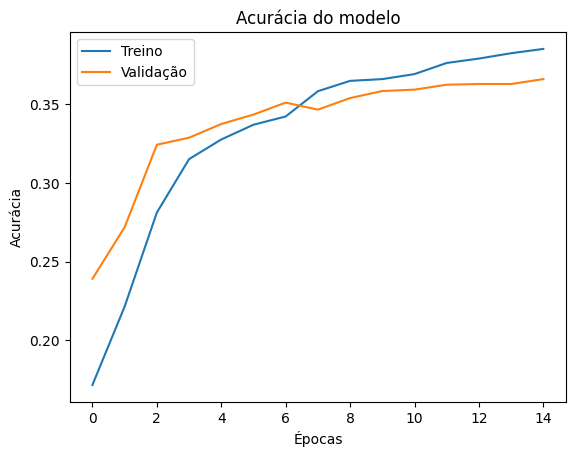

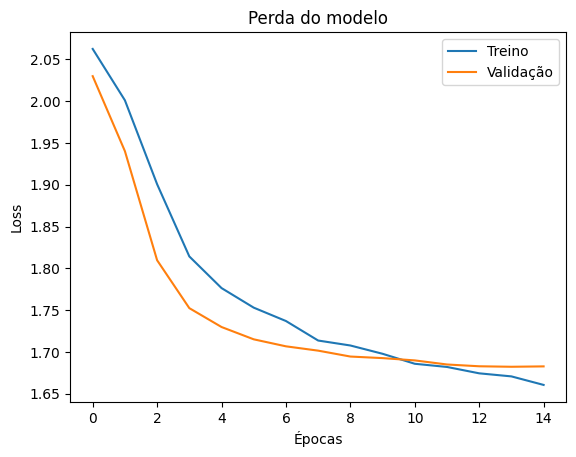

In [ ]:
# 11. Plotar métricas
plt.plot(history.history['categorical_accuracy'], label='Treino')
plt.plot(history.history['val_categorical_accuracy'], label='Validação')
plt.title('Acurácia do modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step


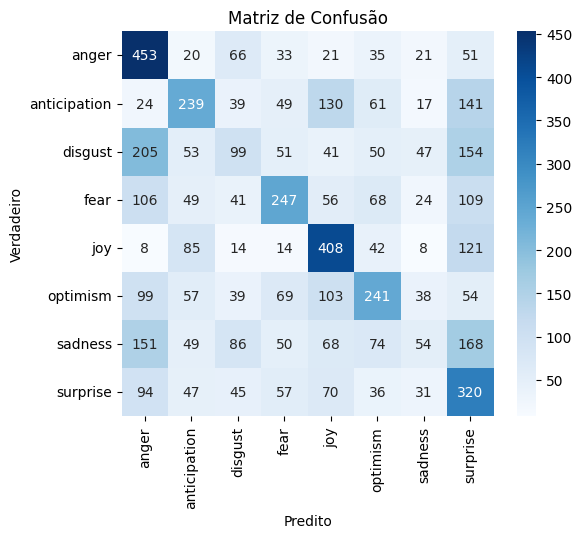



              precision    recall  f1-score   support

       anger       0.40      0.65      0.49       700
anticipation       0.40      0.34      0.37       700
     disgust       0.23      0.14      0.18       700
        fear       0.43      0.35      0.39       700
         joy       0.45      0.58      0.51       700
    optimism       0.40      0.34      0.37       700
     sadness       0.23      0.08      0.11       700
    surprise       0.29      0.46      0.35       700

    accuracy                           0.37      5600
   macro avg       0.35      0.37      0.35      5600
weighted avg       0.35      0.37      0.35      5600



In [ ]:
# 12. Matriz de confusão e classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = encoder_emotion.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print('\n')
print(classification_report(y_true, y_pred, target_names=labels))


## GRU

In [ ]:
# 8. Criar o modelo
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    GRU(16, dropout=0.4, recurrent_dropout=0.4),
    Dropout(0.4),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

# 9. Treinar
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 144, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,768 (69.41 KB)

 Trainable params: 17,768 (69.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - categorical_accuracy: 0.1464 - loss: 2.0730 - val_categorical_accuracy: 0.2203 - val_loss: 2.0299
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - categorical_accuracy: 0.2212 - loss: 2.0175 - val_categorical_accuracy: 0.2574 - val_loss: 1.9649
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - categorical_accuracy: 0.2593 - loss: 1.9529 - val_categorical_accuracy: 0.2842 - val_loss: 1.8993
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - categorical_accuracy: 0.2942 - loss: 1.8915 - val_categorical_accuracy: 0.3129 - val_loss: 1.8333
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - categorical_accuracy: 0.3119 - loss: 1.8325 - val_categorical_accuracy: 0.3395 - val_loss: 1.7778
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - categorical_accuracy: 0.3241 - loss: 1.7962 - val_categorical_accuracy: 0.3393 - val_loss: 1.7577
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - categorical_ac

In [ ]:
# 10. Avaliar
loss, acc = model.evaluate(X_test, y_test)
print(f"Acurácia no teste: {acc:.2%}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - categorical_accuracy: 0.3722 - loss: 1.6767
Acurácia no teste: 36.55%


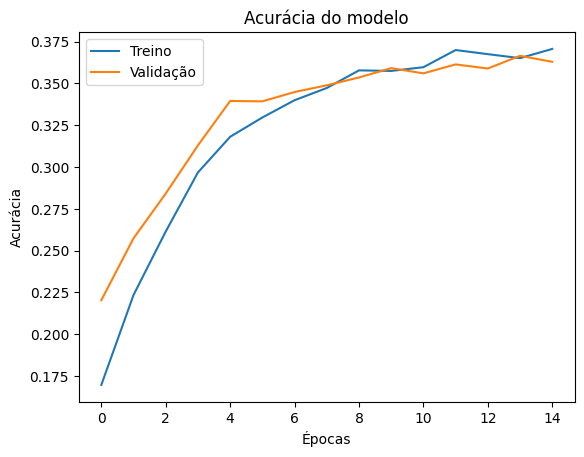

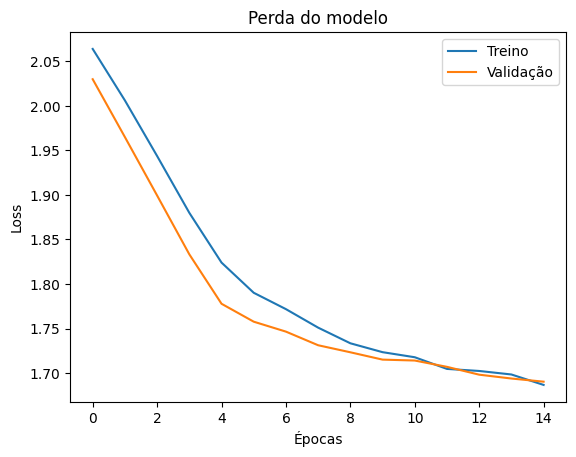

In [ ]:
# 11. Plotar métricas
plt.plot(history.history['categorical_accuracy'], label='Treino')
plt.plot(history.history['val_categorical_accuracy'], label='Validação')
plt.title('Acurácia do modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


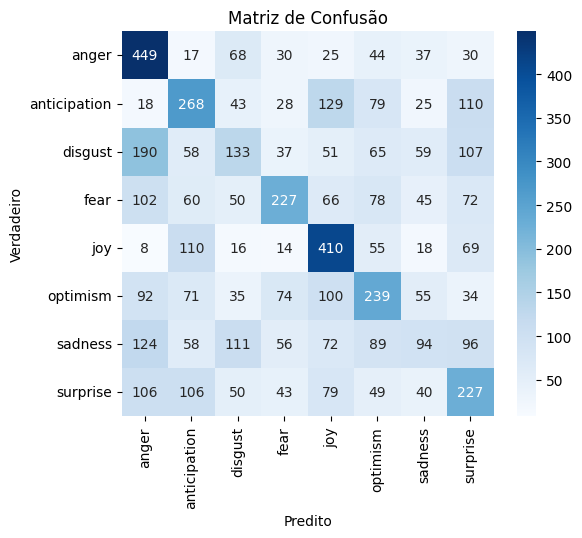



              precision    recall  f1-score   support

       anger       0.41      0.64      0.50       700
anticipation       0.36      0.38      0.37       700
     disgust       0.26      0.19      0.22       700
        fear       0.45      0.32      0.38       700
         joy       0.44      0.59      0.50       700
    optimism       0.34      0.34      0.34       700
     sadness       0.25      0.13      0.18       700
    surprise       0.30      0.32      0.31       700

    accuracy                           0.37      5600
   macro avg       0.35      0.37      0.35      5600
weighted avg       0.35      0.37      0.35      5600



In [ ]:
# 12. Matriz de confusão e classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = encoder_emotion.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print('\n')
print(classification_report(y_true, y_pred, target_names=labels))

## SimpleRNN layer

In [ ]:
# 8. Criar o modelo
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    SimpleRNN(16, dropout=0.4, recurrent_dropout=0.4),
    Dropout(0.4),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

# 9. Treinar
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 144, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,664 (65.09 KB)

 Trainable params: 16,664 (65.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - categorical_accuracy: 0.1305 - loss: 2.3310 - val_categorical_accuracy: 0.1404 - val_loss: 2.0790
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - categorical_accuracy: 0.1281 - loss: 2.2165 - val_categorical_accuracy: 0.1830 - val_loss: 2.0676
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - categorical_accuracy: 0.1317 - loss: 2.1458 - val_categorical_accuracy: 0.1864 - val_loss: 2.0645
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - categorical_accuracy: 0.1308 - loss: 2.1139 - val_categorical_accuracy: 0.1993 - val_loss: 2.0610
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - categorical_accuracy: 0.1371 - loss: 2.0902 - val_categorical_accuracy: 0.1991 - val_loss: 2.0611
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - categorical_accuracy: 0.1416 - loss: 2.0813 - val_categorical_accuracy: 0.2194 - val_loss: 2.0619
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - categorical_accuracy: 0.1

In [ ]:
# 10. Avaliar
loss, acc = model.evaluate(X_test, y_test)
print(f"Acurácia no teste: {acc:.2%}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - categorical_accuracy: 0.2402 - loss: 1.9989
Acurácia no teste: 24.52%


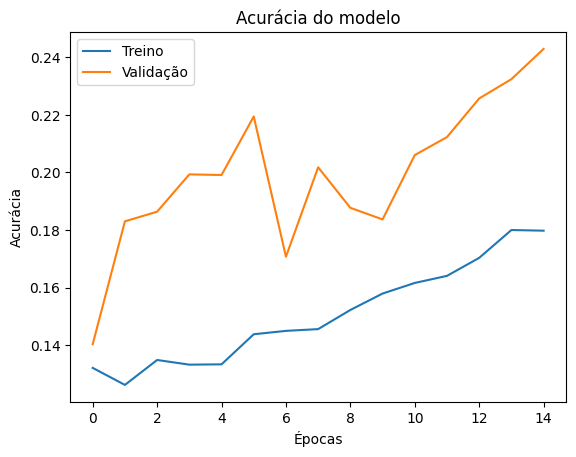

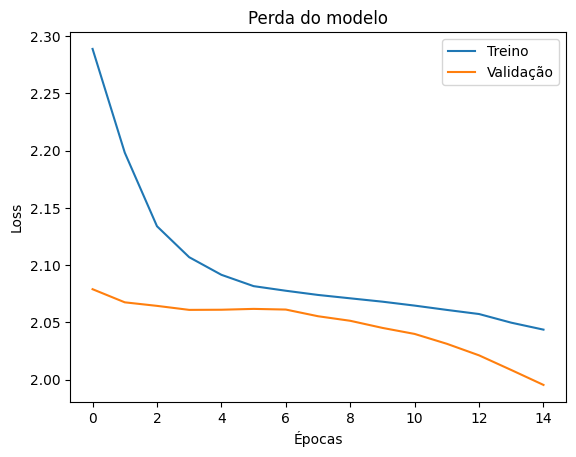

In [ ]:
# 11. Plotar métricas
plt.plot(history.history['categorical_accuracy'], label='Treino')
plt.plot(history.history['val_categorical_accuracy'], label='Validação')
plt.title('Acurácia do modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


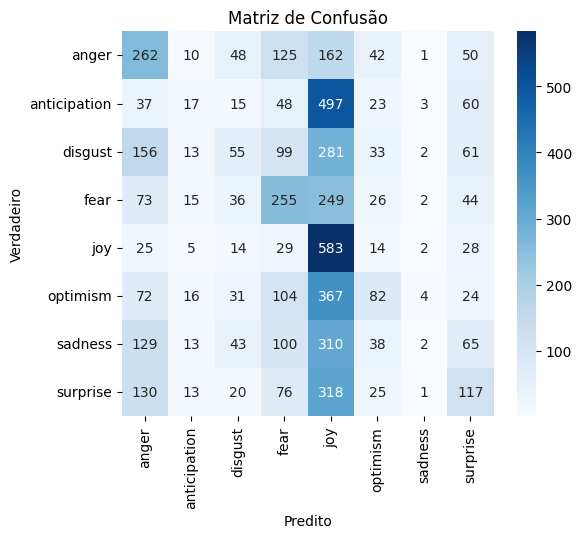



              precision    recall  f1-score   support

       anger       0.30      0.37      0.33       700
anticipation       0.17      0.02      0.04       700
     disgust       0.21      0.08      0.11       700
        fear       0.31      0.36      0.33       700
         joy       0.21      0.83      0.34       700
    optimism       0.29      0.12      0.17       700
     sadness       0.12      0.00      0.01       700
    surprise       0.26      0.17      0.20       700

    accuracy                           0.25      5600
   macro avg       0.23      0.25      0.19      5600
weighted avg       0.23      0.25      0.19      5600



In [ ]:
# 12. Matriz de confusão e classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = encoder_emotion.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print('\n')
print(classification_report(y_true, y_pred, target_names=labels))

## Bidirectional layer

In [ ]:
# 8. Criar o modelo
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    Bidirectional(LSTM(16, dropout=0.4, recurrent_dropout=0.4)),
    Dropout(0.4),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

# 9. Treinar
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 144, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,488 (80.03 KB)

 Trainable params: 20,488 (80.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 36s 204ms/step - categorical_accuracy: 0.1428 - loss: 2.0747 - val_categorical_accuracy: 0.1884 - val_loss: 2.0270
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - categorical_accuracy: 0.1969 - loss: 2.0108 - val_categorical_accuracy: 0.2674 - val_loss: 1.9269
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - categorical_accuracy: 0.2592 - loss: 1.9176 - val_categorical_accuracy: 0.2969 - val_loss: 1.8244
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 202ms/step - categorical_accuracy: 0.2954 - loss: 1.8383 - val_categorical_accuracy: 0.3317 - val_loss: 1.7660
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - categorical_accuracy: 0.3156 - loss: 1.7852 - val_categorical_accuracy: 0.3321 - val_loss: 1.7375
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - categorical_accuracy: 0.3315 - loss: 1.7661 - val_categorical_accuracy: 0.3397 - val_loss: 1.7264
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - categorical_a

In [ ]:
# 10. Avaliar
loss, acc = model.evaluate(X_test, y_test)
print(f"Acurácia no teste: {acc:.2%}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.3631 - loss: 1.6889
Acurácia no teste: 36.57%


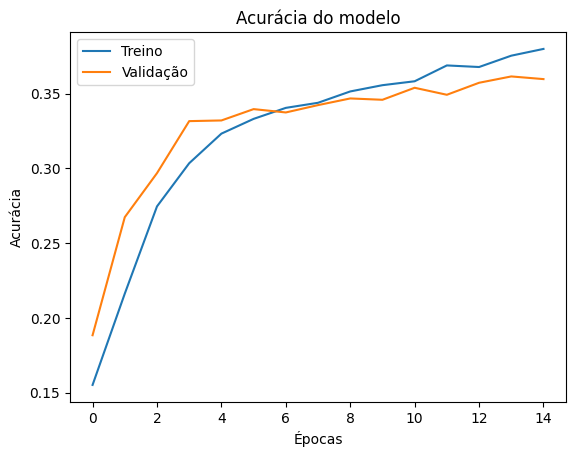

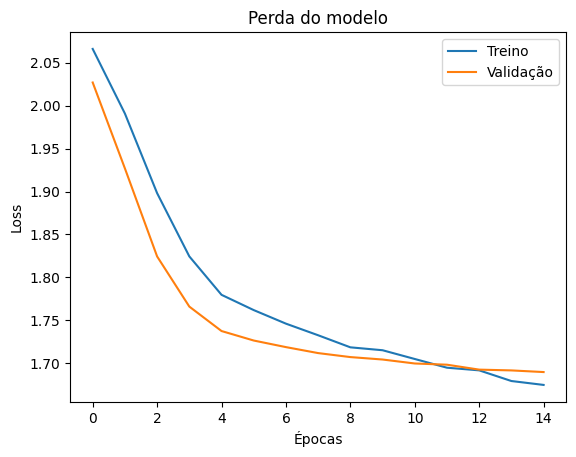

In [ ]:
# 11. Plotar métricas
plt.plot(history.history['categorical_accuracy'], label='Treino')
plt.plot(history.history['val_categorical_accuracy'], label='Validação')
plt.title('Acurácia do modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step


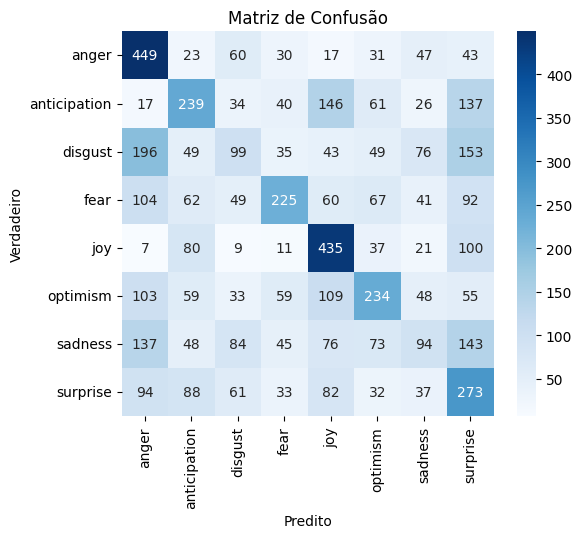



              precision    recall  f1-score   support

       anger       0.41      0.64      0.50       700
anticipation       0.37      0.34      0.35       700
     disgust       0.23      0.14      0.18       700
        fear       0.47      0.32      0.38       700
         joy       0.45      0.62      0.52       700
    optimism       0.40      0.33      0.36       700
     sadness       0.24      0.13      0.17       700
    surprise       0.27      0.39      0.32       700

    accuracy                           0.37      5600
   macro avg       0.36      0.37      0.35      5600
weighted avg       0.36      0.37      0.35      5600



In [ ]:
# 12. Matriz de confusão e classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = encoder_emotion.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print('\n')
print(classification_report(y_true, y_pred, target_names=labels))